#### CSPB 3022(Introduction to Data Science Algorithms Spring 2020)

Name: Kyumsung Lee

# Predicting the power in Combined Cycle Power Plant with linear regression
The CCPP(Combined Cycle Power Plant) is composed of gas turbine and steam turbine. Gas turbine compresses the air and mixes it with fuel, which is then ignited to spin a blade. The spinning energy is converted to electricity. Heat recovery steam generator captures the exhaust heat from gas turbine and generates steam. The steam is delivered to steam turbine to generate more electricity by spinning its blade.
It is important to predict the output of power plant in order to maximize the profit by selling the electricity to as many customers as possible with already predicted amount of electricity. The dataset are collected from a Combined Cycle Power Plant from 2006 to 2011, when the power plant was set to run with full load. The original dataset can be found in https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant [1].  In this project, multi linear regression would be performed to predict the electrical output using four inputs.

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy.builtins import *

### Importing Data
There are 9568 samples in the dataset.  The net hourly **EP**(Electrical Output(Mega Watt)) of CCPP is effected by four inputs(factors).

* **AT**(Ambient Temperature) - Air temperature(Celcius)
* **AP**(Ambient Pressure) - Pressure in gas turbine(Millibar)
* **RH**(Relative Humidity) - Air humidity(Percentage)
* **V** (Exhaust Vaccuum) - Pressure in steam turbine(cmHg)

AT, AP, and RH have effect on gas turbine and  V have effect on steam turbine. The inputs are sampled from various sensors around the plant per second. Then the average is recored per hour.

In [2]:
CCPP = pd.read_excel('Folds5x2_pp.xlsx',sheet_name ='Sheet1' )
CCPP.describe(include='all')

,AT,V,AP,RH,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


### Data types
All input and output data contain numerical value.

In [3]:
print(CCPP.columns)
print(CCPP.dtypes)

Index(['AT', 'V', 'AP', 'RH', 'EP'], dtype='object')
AT    float64
V     float64
AP    float64
RH    float64
EP    float64
dtype: object


### Transfrom data
Different pressure units are used in gas turbine(millibar) and steam turbine(cmHg).  In order to maintain one common pressure in this project, the pressure unit in steam turbine is converted from cmHg to millibar and stored in **SP**(Steam Pressure).

In [4]:
CCPP['SP'] = CCPP.V*13.33
CCPP = CCPP.drop('V',axis=1)
CCPP.describe(include='all')

,AT,AP,RH,EP,SP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,1013.259078,73.308978,454.365009,723.896364
std,7.452473,5.938784,14.600269,17.066995,169.396214
min,1.810000,992.890000,25.560000,420.260000,338.048800
25%,13.510000,1009.100000,63.327500,439.750000,556.394200
50%,20.345000,1012.940000,74.975000,451.550000,694.226400
75%,25.720000,1017.260000,84.830000,468.430000,886.978200
max,37.110000,1033.300000,100.160000,495.760000,1087.194800


### Input data range

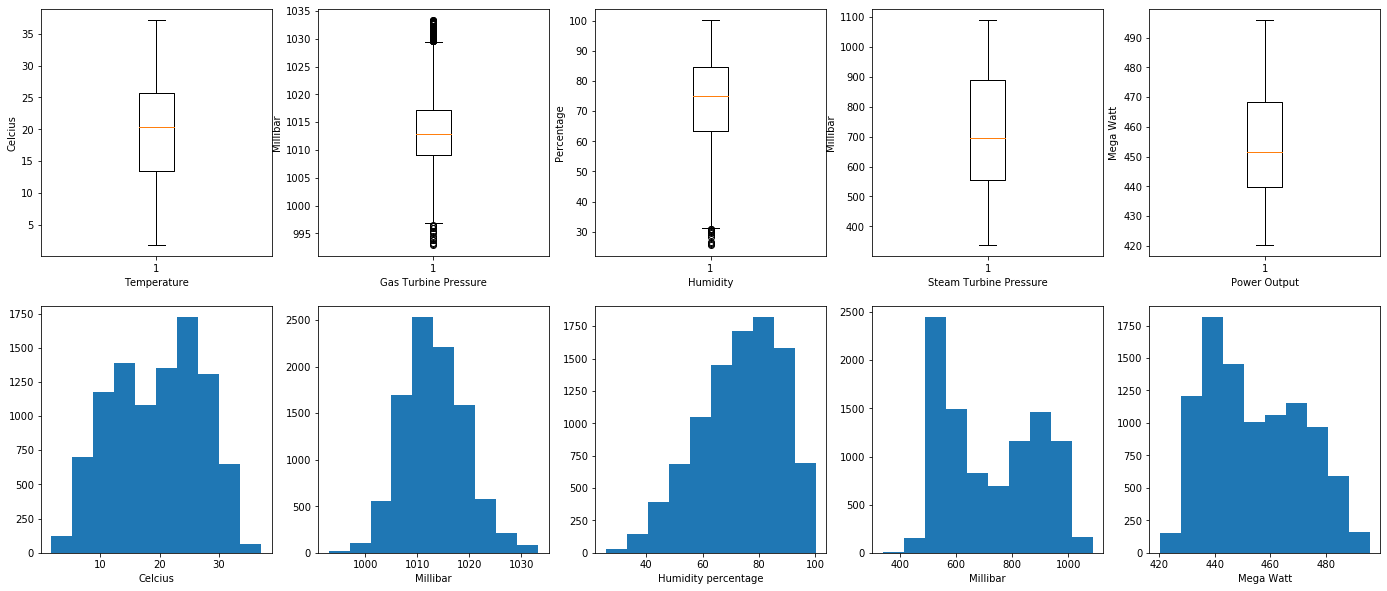

In [5]:
fig,axes = plt.subplots(nrows=2, ncols=5, figsize=(24,10))
axes[0,0].boxplot(CCPP.AT)
axes[0,0].set_xlabel('Temperature')
axes[0,0].set_ylabel('Celcius')
axes[0,1].boxplot(CCPP.AP)
axes[0,1].set_xlabel('Gas Turbine Pressure')
axes[0,1].set_ylabel('Millibar')
axes[0,2].boxplot(CCPP.RH)
axes[0,2].set_xlabel('Humidity')
axes[0,2].set_ylabel('Percentage');
axes[0,3].boxplot(CCPP.SP)
axes[0,3].set_xlabel('Steam Turbine Pressure')
axes[0,3].set_ylabel('Millibar')
axes[0,4].boxplot(CCPP.EP)
axes[0,4].set_xlabel('Power Output')
axes[0,4].set_ylabel('Mega Watt')

axes[1,0].hist(CCPP.AT)
axes[1,0].set_xlabel('Celcius')
axes[1,1].hist(CCPP.AP)
axes[1,1].set_xlabel('Millibar')
axes[1,2].hist(CCPP.RH)
axes[1,2].set_xlabel('Humidity percentage');
axes[1,3].hist(CCPP.SP)
axes[1,3].set_xlabel('Millibar')
axes[1,4].hist(CCPP.EP)
axes[1,4].set_xlabel('Mega Watt')
plt.show();

The whiskers in boxplot represent 1.5 times interquartile range. One interesting thing to point out is that gas turbine pressure has smaller variation comparing to the other inputs. In gas turbine pressure plot , there are many outliers because most of data are concentrated on small interquartile range. Perhaps it is easier to control than other ones.

### Data Validity Check
During data validity check, invalid data should be dropped.  However, no entries are dropped. Therefore, there are no invalid or missing values in the original dataset.

In [6]:
CCPP.EP = pd.to_numeric(CCPP.EP, errors='coerce')
CCPP.AT = pd.to_numeric(CCPP.AT, errors='coerce')
CCPP.SP = pd.to_numeric(CCPP.SP,  errors='coerce')
CCPP.AP = pd.to_numeric(CCPP.AP, errors='coerce')
CCPP.RH = pd.to_numeric(CCPP.RH, errors='coerce')
CCPP = CCPP.dropna(axis=0)
CCPP.describe(include='all')

,AT,AP,RH,EP,SP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,1013.259078,73.308978,454.365009,723.896364
std,7.452473,5.938784,14.600269,17.066995,169.396214
min,1.810000,992.890000,25.560000,420.260000,338.048800
25%,13.510000,1009.100000,63.327500,439.750000,556.394200
50%,20.345000,1012.940000,74.975000,451.550000,694.226400
75%,25.720000,1017.260000,84.830000,468.430000,886.978200
max,37.110000,1033.300000,100.160000,495.760000,1087.194800


## Relationship between data

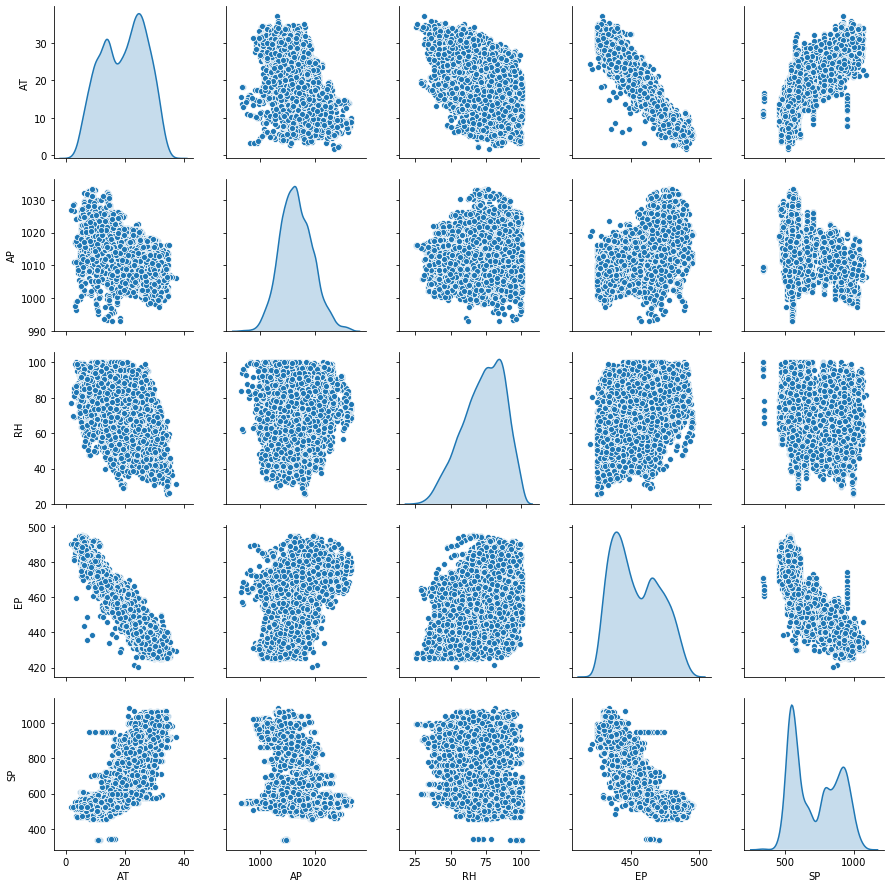

In [7]:
sns.pairplot(CCPP, diag_kind='kde');

Strong positive relation is observed in Temperature-Steam turbine pressure.  Strong negative relation is observed in Steam turbine pressure-Output power and Temperature-Output power.

In [8]:
CCPP.corr()

,AT,AP,RH,EP,SP
AT,1.000000,-0.507549,-0.542535,-0.948128,0.844107
AP,-0.507549,1.000000,0.099574,0.518429,-0.413502
RH,-0.542535,0.099574,1.000000,0.389794,-0.312187
EP,-0.948128,0.518429,0.389794,1.000000,-0.869780
SP,0.844107,-0.413502,-0.312187,-0.869780,1.000000


The same result is also explained by this table. Strong correlations are shown in Temperature-Steam turbine pressure(0.84) and Steam turbine pressure-Output power(-0.87) and Temperature-Output power(-0.95).

### Multi-linear with interactions
All factors are included initially to see how they interact.

In [9]:
CCPP_full = smf.ols(formula = 'EP ~ AT*AP*RH*SP', data = CCPP).fit()
CCPP_full.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     EP   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     9568.
Date:                Mon, 04 May 2020   Prob (F-statistic):               0.00
Time:                        07:19:12   Log-Likelihood:                -27450.
No. Observations:                9568   AIC:                         5.493e+04
Df Residuals:                    9552   BIC:                         5.505e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    4433.5308    795.016      5.577      0.000    2875.130    5991.932
AT           -208.2538     32.610     -6.386      0.000    -272.176    -144.331
AP             -3.8570      0.785     -4.915      0.000      -5.395      -2.319
AT:AP           0.2035      0.032      6.318      0.000       0.140       0.267
RH            -26.6896     10.183     -2.621      0.009     -46.651      -6.728
AT:RH           1.7655      0.431      4.099      0.000       0.921       2.610
AP:RH           0.0264      0.010      2.621      0.009       0.007       0.046
AT:AP:RH       -0.0018      0.000     -4.122      0.000      -0.003      -0.001
SP             -6.3982      1.343     -4.764      0.000      -9.031      -3.765
AT:SP           0.2872      0.048      5.951      0.000       0.193       0.382
AP:SP           0.0063      0.001      4.722      0.000       0.004       0.009
AT:AP:SP       -0.0003   4.77e-05     -5.926      0.000      -0.000      -0.000
RH:SP           0.0411      0.017      2.362      0.018       0.007       0.075
AT:RH:SP       -0.0023      0.001     -3.531      0.000      -0.004      -0.001
AP:RH:SP    -4.057e-05   1.72e-05     -2.362      0.018   -7.42e-05    -6.9e-06
AT:AP:RH:SP  2.253e-06   6.37e-07      3.539      0.000    1.01e-06     3.5e-06
==============================================================================
Omnibus:                     1581.223   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10927.382
Skew:                          -0.612   Prob(JB):                         0.00
Kurtosis:                       8.090   Cond. No.                     2.21e+13
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.21e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Because all P-values are significant, all factors are included. 

### Leverage

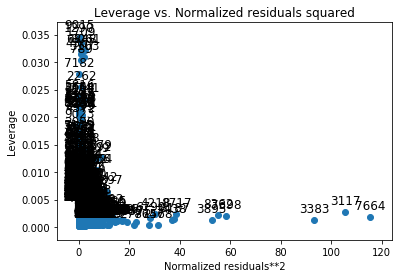

In [10]:
sm.graphics.plot_leverage_resid2(CCPP_full, alpha=0.05);

### Identify and Clean
The leverage vs normal plot indicates that some row have small leverage with high residuals.

In [11]:
Outliers = [3382,3383,3884,3116,3117,3118,7663,7664,7665]
CCPP.loc[Outliers]

,AT,AP,RH,EP,SP
3382,25.34,1013.25,50.80,457.12,659.8350
3383,6.22,1012.05,86.88,443.73,531.2005
3884,30.75,1011.02,54.76,429.18,979.7550
3116,14.86,1018.30,49.46,466.38,595.9843
3117,8.74,1015.18,61.97,438.63,483.8790
3118,16.55,1009.97,96.54,455.80,615.5794
7663,19.31,1013.65,41.54,463.35,580.6548
7664,7.14,1016.60,97.09,435.58,549.4626
7665,28.18,1011.56,48.03,432.72,948.2962


Sudden temperature drop is observed in the outliers. After the outliers are dropped, $R^2$ value is improved.

In [12]:
Outliers = [3117,3383,7664]
CCPP_Filter = CCPP.drop(Outliers)

In [13]:
smf.ols(formula = 'EP ~ AT*AP*RH*SP', data = CCPP_Filter).fit().rsquared

0.9396339170692647

### Train data and Test data
Dataset would be splitted into Train and Test data. Train data is collected from even rows and test data is collected from odd rows.

In [14]:
CCPP_Train = CCPP_Filter.loc[::2]
CCPP_Test  = CCPP_Filter.loc[1::2]

### Single Factors interaction

AT 0.9023023467292159
RH 0.9231409159721488
SP 0.929798905174033
AP 0.930082467082746


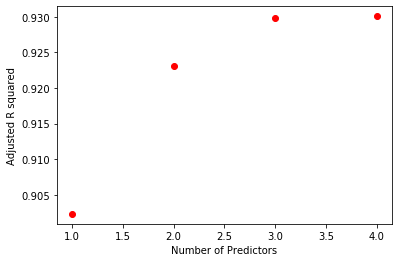

In [15]:
Factors = [ 'AT', 'AP', 'RH', 'SP' ]
Chosen_Factors = []
Rsqaured = []
FactorInString = ''

def IsExist( target ):
    for factor in Chosen_Factors:
        if factor == target:
            return True
    return False
        
MaxVal = 0

for factor in Factors:
    for feature in Factors:
        if IsExist(feature) == False:
            NewVal = smf.ols(formula = 'EP ~ ' + FactorInString + feature, data = CCPP_Train).fit().rsquared_adj            
            if MaxVal < NewVal:
                MaxVal = NewVal
                MaxFeature = feature
    Chosen_Factors.append(MaxFeature)
    Rsqaured.append(MaxVal)
    FactorInString = FactorInString + ' + ' + MaxFeature + '+'
    print(MaxFeature, MaxVal)
    
x = [ ii for ii in range(1,len(Chosen_Factors)+1)]
plt.plot(x,Rsqaured,'ro');
plt.xlabel('Number of Predictors');
plt.ylabel('Adjusted R squared');

The best Adjusted$-R^2$ is 0.93 with all single inputs

### Multiple Factors interaction

AT 0.9023023467292159
RH:SP 0.9324444975125434
AT:AP:SP 0.9335142837779935
SP 0.936501350968789
AT:SP 0.9372445724384995
AT:RH 0.9375337614019934
AP:RH 0.9376242210025613
RH 0.9376570329381887
AP:SP 0.9380544047081159
AT:AP:RH 0.9388669219763993
AT:RH:SP 0.9388896030253506
AT:AP 0.9388940510639217
AP 0.9392409572096027
AP:AT:RH:SP 0.9393140915778719


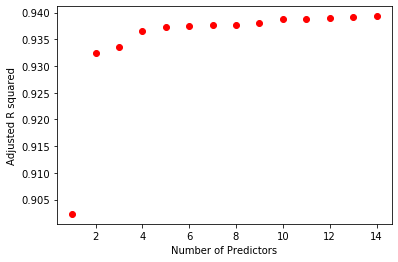

In [16]:
Factors = [ 'AT', 'AP', 'RH', 'SP', 'AT:AP', 'AT:RH', 'AT:SP', 'AP:RH', 'AP:SP', 'RH:SP', 'AT:AP:RH', 'AT:AP:SP', 'AT:RH:SP', 'AP:AT:RH:SP']
Chosen_Factors = []
Train_Rsqaured = []
FactorInString = ''

def IsExist( target ):
    for factor in Chosen_Factors:
        if factor == target:
            return True
    return False
        
MaxVal = 0

for factor in Factors:
    ValAdded = False
    for feature in Factors:
        if IsExist(feature) == False:
            NewVal = smf.ols(formula = 'EP ~ ' + FactorInString + feature, data = CCPP_Train).fit().rsquared_adj            
            if MaxVal < NewVal:
                ValAdded = True
                MaxVal = NewVal
                MaxFeature = feature
    if ValAdded == True:
        Chosen_Factors.append(MaxFeature)
        Train_Rsqaured.append(MaxVal)
        FactorInString = FactorInString + ' + ' + MaxFeature + '+'
        print(MaxFeature, MaxVal)
    
x = [ ii for ii in range(1,len(Chosen_Factors)+1)]
plt.plot(x,Train_Rsqaured,'ro');
plt.xlabel('Number of Predictors');
plt.ylabel('Adjusted R squared');

The best Adjusted −$𝑅^2$  is 0.94 with combintaion of factors.  However, AT + RH:SP(0.932) already becomes greater than the max value(0.93) of single factors.  Therefore, AT + RH:SP might be the best option with minimun number of factors.

### Test
Adjusted-$R^2$ of test data set is plotted with Adjusted-$R^2$ of train data set.

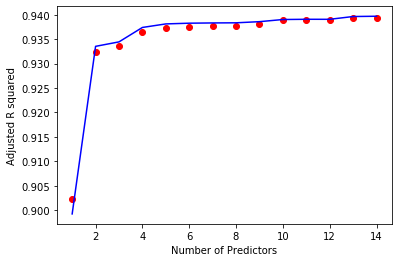

In [17]:
Test_Factors = ''
Test_Rsqaured = []

for factor in Chosen_Factors:
    Test_Factors = Test_Factors + '+' + factor
    Test_Rsqaured.append(smf.ols(formula = 'EP ~  ' + Test_Factors, data = CCPP_Test).fit().rsquared_adj)
    
#print(Test_Rsqaured);
plt.plot(x,Train_Rsqaured,'ro');
plt.plot(x,Test_Rsqaured,'b');
plt.xlabel('Number of Predictors');
plt.ylabel('Adjusted R squared');

Adjusted-$R^2$ of test data is almost same as Adjusted-$R^2$ of train data.

### Parameters of optimal model

In [18]:
model = smf.ols(formula = 'EP ~ AT + RH:SP', data = CCPP_Test).fit()
print(model.params)
print(model.rsquared_adj)

Intercept    506.588848
AT            -2.016946
RH:SP         -0.000241
dtype: float64
0.9335230197987514


It means the output power is effected by temperature more than RH:SP.

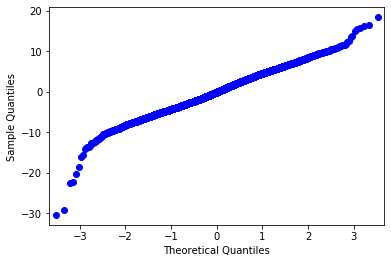

In [19]:
sm.qqplot(model.resid);

There are few outliers in the lower range, but the model performs well in general.

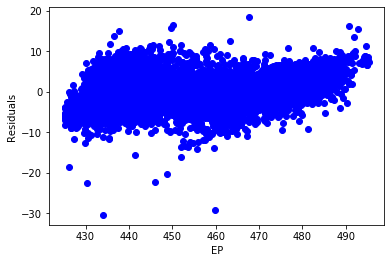

In [20]:
plt.plot(CCPP_Test.EP,model.resid,'bo');
plt.xlabel('EP')
plt.ylabel('Residuals');

The outliers from prevoius plot matches the outliers in this plot.  Let's find out the outliers.

In [21]:
outliers = model.resid[model.resid < -15]
CCPP_Test.loc[outliers.index]

,AT,AP,RH,EP,SP
1919,13.32,1020.22,88.30,451.93,555.8610
2787,12.68,1013.86,83.26,448.69,599.9833
3895,14.69,1023.43,78.17,434.12,661.7012
4715,18.94,1010.22,75.45,441.41,625.5769
7375,18.60,1009.80,86.42,430.38,782.6043
7427,23.54,1009.44,65.48,426.24,904.1739
7647,13.78,1014.49,81.86,445.98,534.5330
8362,3.40,1011.10,83.43,459.86,528.4012


Let's remove the outliers.

Adjusted R^2 is  0.9363597370559654


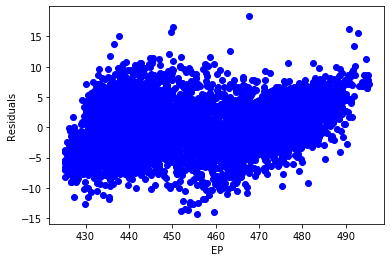

In [22]:
CCPP_Test_Filter = CCPP_Test.drop(outliers.index)
model_Filter = smf.ols(formula = 'EP ~ AT + RH:SP', data = CCPP_Test_Filter).fit()
print("Adjusted R^2 is ", model_Filter.rsquared_adj)
plt.plot(CCPP_Test_Filter.EP,model_Filter.resid,'bo');
plt.xlabel('EP')
plt.ylabel('Residuals');

The adjusted-$R^2$ is increased from 0.933 to 0.936.

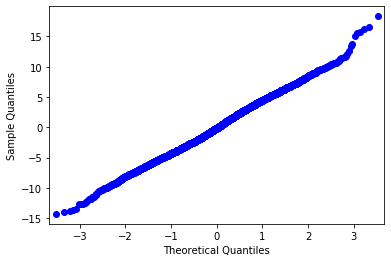

In [23]:
sm.qqplot(model_Filter.resid);

The graph is almost straight line, which means the model fits well.

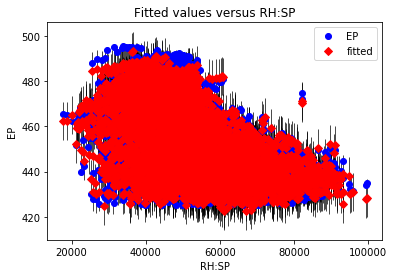

In [24]:
sm.graphics.plot_fit(model_Filter,2);

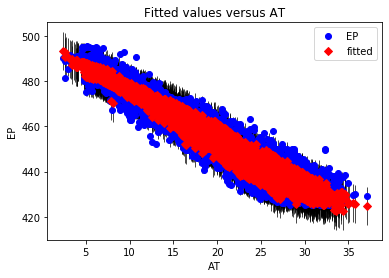

In [25]:
sm.graphics.plot_fit(model_Filter,1);

Not many outliers are observed.  The model fits the output well.

In [26]:
model_Filter.f_test('AT=RH:SP=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[35114.34506034]]), p=0.0, df_denom=4.77e+03, df_num=2>

It is very unlikely that AT and RH:SP become zero.

### Summary
The original data was splitted into test and train data.  Multi linear regression model was trained with train data and optimal parameters with inputs are discovered.  Then model predicted the output power of CCPP using test data with Adjusted-$R^2$ of 0.936.  The formula was EP=AT+RH:SP.  Temperature was the most important factor that effects the output power because (1) it has the largest correation value with EP(-0.95), (2) during single/multi factors interaction analysis, temperature increased Adjusted-$R^2$ the most.  Lower temperature helped generating more power because the temperature model parameter was negative value.  This finding was also suppored by this research paper[2]. Two different methods are used to find multi linear regression model(single vs multi factors interaction).  Single factors interaction was faster but did not provide the best Adjusted-$R^2$. Multi factors interaction was slower but provided the best Adjusted-$R^2$. 

### Reference
[1] Pınar Tüfekci & Heysem Kaya, Sept 2014. Combined Power Plant Data Set https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant.

[2] Yousef S. H. Najjar & Yaman Mohammad Ali Manaserh, Nov 2018. Aligning Combined Cycle Power Plant Performance with Field Measurements https://link.springer.com/article/10.1007/s13369-018-3615-2